In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import TextVectorization
import re,string
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,LayerNormalization

In [2]:
# Load the dataset
df = pd.read_excel("Allergy.xlsx",header=0)

In [3]:
# Set display options to show full content without truncation
pd.set_option('display.max_colwidth', None)
NewData = df[['Patient','Doctor']]

In [4]:
print(f'Dataframe size: {len(NewData)}')
NewData.head(20)

Dataframe size: 310


,Patient,Doctor
0,"Doctor, I've been feeling really strange lately. I had a reaction after eating something, and my throat felt like it was closing up. I'm really worried. Can you help me?","Of course, I'll do my best to help you. It sounds like you may have experienced an allergic reaction. Can you tell me more about what happened?"
1,"Well, I was at a restaurant and I had this dish with shrimp. Shortly after I finished eating, my lips started to swell, and I had difficulty breathing. I've never had this happen before, and it scared me.","I understand your concern. Based on your symptoms, it's possible that you had a severe allergic reaction called anaphylaxis. This is a serious condition that requires immediate medical attention. Have you experienced any other symptoms, such as hives, itching, or lightheadedness?"
2,"Yes, actually, I did notice some hives on my arms and chest, and I felt lightheaded and dizzy. I had no idea this could happen from eating shrimp. What exactly is anaphylaxis?","That's probably what's causing your reaction. Pork is a common allergen, and it can cause a variety of symptoms, including hives, difficulty breathing, and even anaphylaxis."
3,"Anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen, such as shrimp in your case. It can affect multiple systems in your body and can be life-threatening if not treated promptly. Common symptoms include swelling of the lips, face, or throat, difficulty breathing, hives or rash, and a drop in blood pressure leading to dizziness or fainting.",That sounds really serious! I had no idea an allergic reaction could be so dangerous. What should I do if it happens again?
4,"Good morning, Doctor. I've been experiencing some unusual symptoms, and I'm not sure what's going on. I noticed some skin issues and recently had a blood test done. Can you please take a look at the reports and help me understand what's happening?","Good morning. Of course, I'll be happy to assist you. Please hand me your reports, and let's discuss your symptoms in detail. What specific skin issues have you been experiencing?"
5,"Well, I've been having frequent rashes and hives on different parts of my body. They appear as red, itchy patches, and they come and go randomly. It's quite uncomfortable, and I'm not sure what triggers them.","I see. Skin rashes and hives can be indicative of an allergic reaction. It's important to identify the underlying cause. Now, let's take a look at your blood test results. Could you please pass them to me?"
6,"Here are the reports, Doctor. I hope they can provide some insight into my condition.",Thank you. Let me review these reports.
7,"Doctor, I had a really scary experience after eating pork yesterday. My face swelled up, and I had difficulty breathing. I think it might have been an allergic reaction. Can you help me understand what happened?",I'm sorry to hear about your distressing experience. Allergic reactions can indeed occur after consuming certain foods. Let's discuss your symptoms in more detail. Did you notice any other reactions apart from the facial swelling and difficulty breathing?
8,"Yes, I also had hives on my body, and I felt quite dizzy. It was really frightening, and I had no idea that this could happen from eating pork. Is it possible that I have an allergy to pork?","It's possible that you have developed an allergy to pork. Allergic reactions can vary from person to person, and some individuals can be allergic to specific types of meat. To better understand your condition, it would be helpful to review your skin and blood test reports. Can you please provide me with those?"
9,"Certainly, Doctor. Here are the reports. I hope they can shed some light on what's happening.","Thank you. Let me take a look at the report .Based on your blood test results, your IgE levels are elevated, indicating a possible allergic reaction. Additionally, your skin prick test shows a positive reaction to p

In [5]:
NewData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Patient  287 non-null    object
 1   Doctor   300 non-null    object
dtypes: object(2)
memory usage: 5.0+ KB


C:\Users\Nuwanga Wijamuni\AppData\Local\Temp\ipykernel_10048\1690811942.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NewData['question Tokens'] = NewData['Patient'].apply(lambda x: len(str(x).split()))


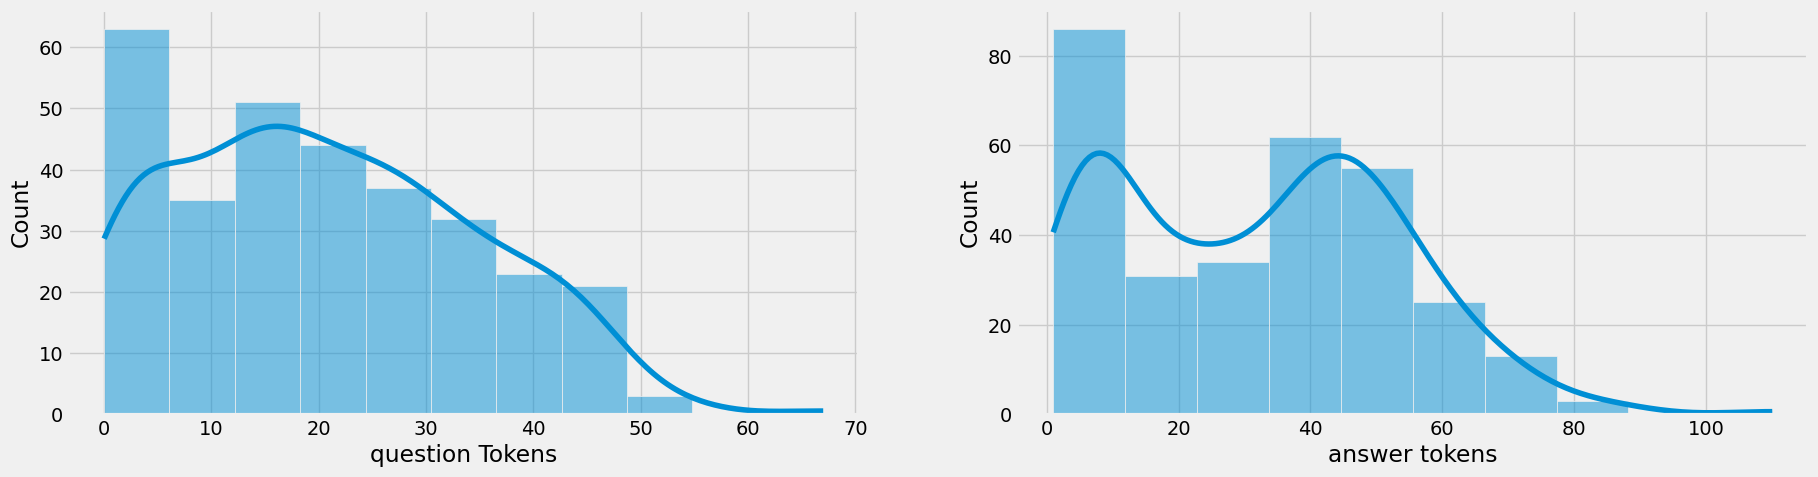

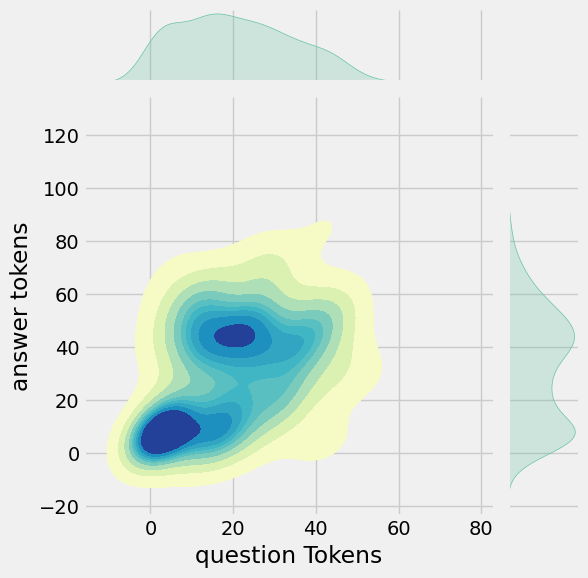

In [6]:
NewData['question Tokens'] = NewData['Patient'].apply(lambda x: len(str(x).split()))
NewData['answer tokens'] = NewData['Doctor'].apply(lambda x: len(str(x).split()))
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
sns.set_palette('Set2')

sns.histplot(x=NewData['question Tokens'], data=NewData, kde=True, ax=ax[0])
sns.histplot(x=NewData['answer tokens'], data=NewData, kde=True, ax=ax[1])
sns.jointplot(x='question Tokens', y='answer tokens', data=NewData, kind='kde', fill=True, cmap='YlGnBu')

plt.show()
plt.show()

In [7]:

def clean_text(text):
    text=re.sub('-',' ',text.lower())
    text=re.sub('[.]',' . ',text)
    text=re.sub('[1]',' 1 ',text)
    text=re.sub('[2]',' 2 ',text)
    text=re.sub('[3]',' 3 ',text)
    text=re.sub('[4]',' 4 ',text)
    text=re.sub('[5]',' 5 ',text)
    text=re.sub('[6]',' 6 ',text)
    text=re.sub('[7]',' 7 ',text)
    text=re.sub('[8]',' 8 ',text)
    text=re.sub('[9]',' 9 ',text)
    text=re.sub('[0]',' 0 ',text)
    text=re.sub('[,]',' , ',text)
    text=re.sub('[?]',' ? ',text)
    text=re.sub('[!]',' ! ',text)
    text=re.sub('[$]',' $ ',text)
    text=re.sub('[&]',' & ',text)
    text=re.sub('[/]',' / ',text)
    text=re.sub('[:]',' : ',text)
    text=re.sub('[;]',' ; ',text)
    text=re.sub('[*]',' * ',text)
    text=re.sub('[\']',' \' ',text)
    text=re.sub('[\"]',' \" ',text)
    text=re.sub('\t',' ',text)
    return text

In [8]:
NewData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Patient          287 non-null    object
 1   Doctor           300 non-null    object
 2   question Tokens  310 non-null    int64 
 3   answer tokens    310 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 9.8+ KB


In [9]:
NewData.drop(columns=['answer tokens', 'question Tokens'], inplace=True)
NewData['encoder_inputs'] = NewData['Patient'].astype(str).apply(clean_text)
NewData['decoder_targets'] = NewData['Doctor'].apply(lambda x: clean_text(x) if pd.notnull(x) else '')
NewData['decoder_targets'] += ' <end>'
NewData['decoder_inputs'] = '<start> ' + NewData['Doctor'].apply(lambda x: clean_text(x) if pd.notnull(x) else '')
NewData['decoder_inputs'] += ' <end>'
NewData.head(10)

,Patient,Doctor,encoder_inputs,decoder_targets,decoder_inputs
0,"Doctor, I've been feeling really strange lately. I had a reaction after eating something, and my throat felt like it was closing up. I'm really worried. Can you help me?","Of course, I'll do my best to help you. It sounds like you may have experienced an allergic reaction. Can you tell me more about what happened?","doctor , i ' ve been feeling really strange lately . i had a reaction after eating something , and my throat felt like it was closing up . i ' m really worried . can you help me ?","of course , i ' ll do my best to help you . it sounds like you may have experienced an allergic reaction . can you tell me more about what happened ? <end>","<start> of course , i ' ll do my best to help you . it sounds like you may have experienced an allergic reaction . can you tell me more about what happened ? <end>"
1,"Well, I was at a restaurant and I had this dish with shrimp. Shortly after I finished eating, my lips started to swell, and I had difficulty breathing. I've never had this happen before, and it scared me.","I understand your concern. Based on your symptoms, it's possible that you had a severe allergic reaction called anaphylaxis. This is a serious condition that requires immediate medical attention. Have you experienced any other symptoms, such as hives, itching, or lightheadedness?","well , i was at a restaurant and i had this dish with shrimp . shortly after i finished eating , my lips started to swell , and i had difficulty breathing . i ' ve never had this happen before , and it scared me .","i understand your concern . based on your symptoms , it ' s possible that you had a severe allergic reaction called anaphylaxis . this is a serious condition that requires immediate medical attention . have you experienced any other symptoms , such as hives , itching , or lightheadedness ? <end>","<start> i understand your concern . based on your symptoms , it ' s possible that you had a severe allergic reaction called anaphylaxis . this is a serious condition that requires immediate medical attention . have you experienced any other symptoms , such as hives , itching , or lightheadedness ? <end>"
2,"Yes, actually, I did notice some hives on my arms and chest, and I felt lightheaded and dizzy. I had no idea this could happen from eating shrimp. What exactly is anaphylaxis?","That's probably what's causing your reaction. Pork is a common allergen, and it can cause a variety of symptoms, including hives, difficulty breathing, and even anaphylaxis.","yes , actually , i did notice some hives on my arms and chest , and i felt lightheaded and dizzy . i had no idea this could happen from eating shrimp . what exactly is anaphylaxis ?","that ' s probably what ' s causing your reaction . pork is a common allergen , and it can cause a variety of symptoms , including hives , difficulty breathing , and even anaphylaxis . <end>","<start> that ' s probably what ' s causing your reaction . pork is a common allergen , and it can cause a variety of symptoms , including hives , difficulty breathing , and even anaphylaxis . <end>"
3,"Anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen, such as shrimp in your case. It can affect multiple systems in your body and can be life-threatening if not treated promptly. Common symptoms include swelling of the lips, face, or throat, difficulty breathing, hives or rash, and a drop in blood pressure leading to dizziness or fainting.",That sounds really serious! I had no idea an allergic reaction could be so dangerous. What should I do if it happens again?,"anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen , such as shrimp in your case . it can affect multiple systems in your body and can be life threatening if not treated promptly . common symptoms include swelling of the lips , face , or throat , difficulty brea

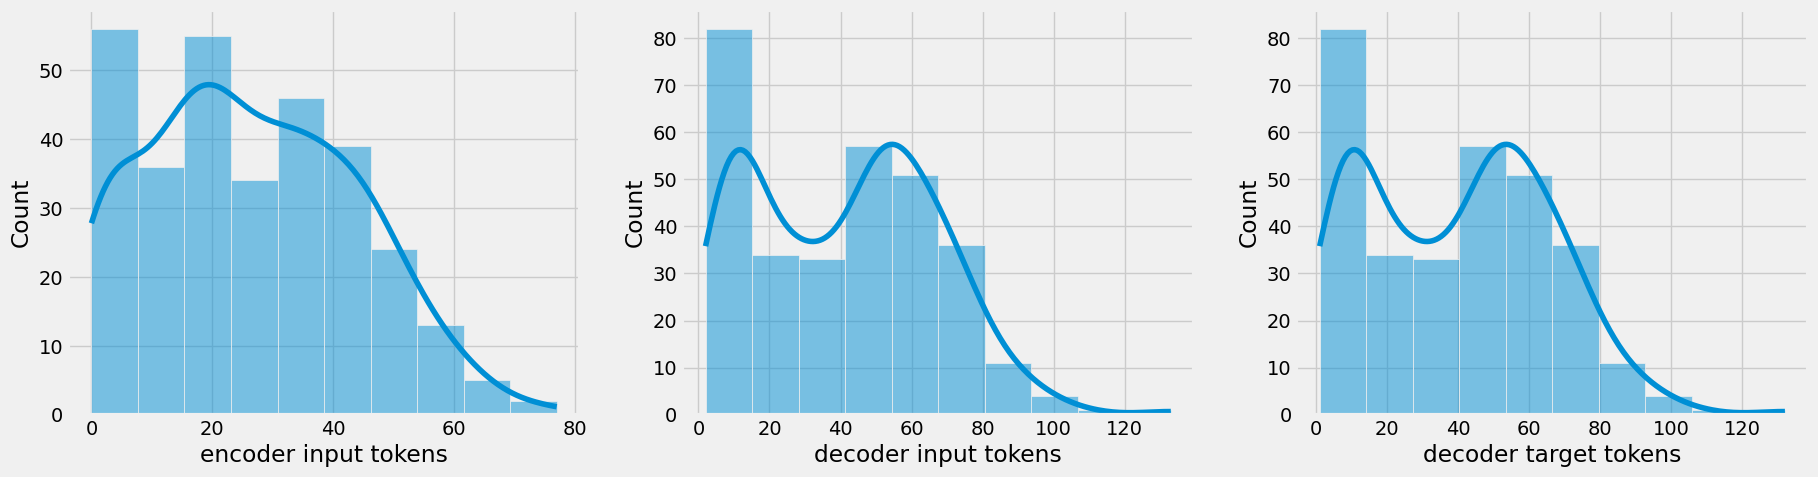

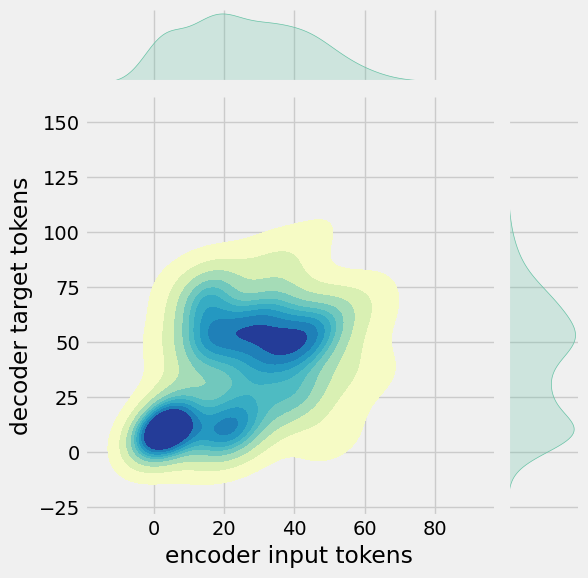

In [10]:
NewData['encoder input tokens']=NewData['encoder_inputs'].apply(lambda x:len(x.split()))
NewData['decoder input tokens']=NewData['decoder_inputs'].apply(lambda x:len(x.split()))
NewData['decoder target tokens']=NewData['decoder_targets'].apply(lambda x:len(x.split()))
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
sns.set_palette('Set2')
sns.histplot(x=NewData['encoder input tokens'],data=NewData,kde=True,ax=ax[0])
sns.histplot(x=NewData['decoder input tokens'],data=NewData,kde=True,ax=ax[1])
sns.histplot(x=NewData['decoder target tokens'],data=NewData,kde=True,ax=ax[2])
sns.jointplot(x='encoder input tokens',y='decoder target tokens',data=NewData,kind='kde',fill=True,cmap='YlGnBu')
plt.show()

In [11]:
max_encoder_input_row = NewData['encoder_inputs'].str.split().str.len().argmax()
max_encoder_input = NewData.loc[max_encoder_input_row, 'encoder_inputs']

print(f"After preprocessing: {' '.join(max_encoder_input.split())}")
print(f"Max encoder input length: {NewData['encoder_inputs'].str.split().str.len().max()}")
print(f"Max decoder input length: {NewData['decoder_inputs'].str.split().str.len().max()}")
print(f"Max decoder target length: {NewData['decoder_targets'].str.split().str.len().max()}")

After preprocessing: anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen , such as shrimp in your case . it can affect multiple systems in your body and can be life threatening if not treated promptly . common symptoms include swelling of the lips , face , or throat , difficulty breathing , hives or rash , and a drop in blood pressure leading to dizziness or fainting .
Max encoder input length: 77
Max decoder input length: 133
Max decoder target length: 132


In [12]:
NewData.head()

,Patient,Doctor,encoder_inputs,decoder_targets,decoder_inputs,encoder input tokens,decoder input tokens,decoder target tokens
0,"Doctor, I've been feeling really strange lately. I had a reaction after eating something, and my throat felt like it was closing up. I'm really worried. Can you help me?","Of course, I'll do my best to help you. It sounds like you may have experienced an allergic reaction. Can you tell me more about what happened?","doctor , i ' ve been feeling really strange lately . i had a reaction after eating something , and my throat felt like it was closing up . i ' m really worried . can you help me ?","of course , i ' ll do my best to help you . it sounds like you may have experienced an allergic reaction . can you tell me more about what happened ? <end>","<start> of course , i ' ll do my best to help you . it sounds like you may have experienced an allergic reaction . can you tell me more about what happened ? <end>",40,35,34
1,"Well, I was at a restaurant and I had this dish with shrimp. Shortly after I finished eating, my lips started to swell, and I had difficulty breathing. I've never had this happen before, and it scared me.","I understand your concern. Based on your symptoms, it's possible that you had a severe allergic reaction called anaphylaxis. This is a serious condition that requires immediate medical attention. Have you experienced any other symptoms, such as hives, itching, or lightheadedness?","well , i was at a restaurant and i had this dish with shrimp . shortly after i finished eating , my lips started to swell , and i had difficulty breathing . i ' ve never had this happen before , and it scared me .","i understand your concern . based on your symptoms , it ' s possible that you had a severe allergic reaction called anaphylaxis . this is a serious condition that requires immediate medical attention . have you experienced any other symptoms , such as hives , itching , or lightheadedness ? <end>","<start> i understand your concern . based on your symptoms , it ' s possible that you had a severe allergic reaction called anaphylaxis . this is a serious condition that requires immediate medical attention . have you experienced any other symptoms , such as hives , itching , or lightheadedness ? <end>",47,53,52
2,"Yes, actually, I did notice some hives on my arms and chest, and I felt lightheaded and dizzy. I had no idea this could happen from eating shrimp. What exactly is anaphylaxis?","That's probably what's causing your reaction. Pork is a common allergen, and it can cause a variety of symptoms, including hives, difficulty breathing, and even anaphylaxis.","yes , actually , i did notice some hives on my arms and chest , and i felt lightheaded and dizzy . i had no idea this could happen from eating shrimp . what exactly is anaphylaxis ?","that ' s probably what ' s causing your reaction . pork is a common allergen , and it can cause a variety of symptoms , including hives , difficulty breathing , and even anaphylaxis . <end>","<start> that ' s probably what ' s causing your reaction . pork is a common allergen , and it can cause a variety of symptoms , including hives , difficulty breathing , and even anaphylaxis . <end>",38,38,37
3,"Anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen, such as shrimp in your case. It can affect multiple systems in your body and can be life-threatening if not treated promptly. Common symptoms include swelling of the lips, face, or throat, difficulty breathing, hives or rash, and a drop in blood pressure leading to dizziness or fainting.",That sounds really serious! I had no idea an allergic reaction could be so dangerous. What should I do if it happens again?,"anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen , such as shrimp in your case . it can affect multiple systems in your body and can be life threatening if not treated p

In [13]:
NewData.drop(columns=['Patient','Doctor','encoder input tokens','decoder input tokens','decoder target tokens'],axis=1,inplace=True)
params={
    "vocab_size":2500,
    "max_sequence_length":40,
    "learning_rate":0.008,
    "batch_size":149,
    "lstm_cells":256,
    "embedding_dim":256,
    "buffer_size":10000
}

In [14]:
learning_rate=params['learning_rate']
batch_size=params['batch_size']
embedding_dim=params['embedding_dim']
lstm_cells=params['lstm_cells']
vocab_size=params['vocab_size']
buffer_size=params['buffer_size']
max_sequence_length=params['max_sequence_length']
NewData.head(10)

,encoder_inputs,decoder_targets,decoder_inputs
0,"doctor , i ' ve been feeling really strange lately . i had a reaction after eating something , and my throat felt like it was closing up . i ' m really worried . can you help me ?","of course , i ' ll do my best to help you . it sounds like you may have experienced an allergic reaction . can you tell me more about what happened ? <end>","<start> of course , i ' ll do my best to help you . it sounds like you may have experienced an allergic reaction . can you tell me more about what happened ? <end>"
1,"well , i was at a restaurant and i had this dish with shrimp . shortly after i finished eating , my lips started to swell , and i had difficulty breathing . i ' ve never had this happen before , and it scared me .","i understand your concern . based on your symptoms , it ' s possible that you had a severe allergic reaction called anaphylaxis . this is a serious condition that requires immediate medical attention . have you experienced any other symptoms , such as hives , itching , or lightheadedness ? <end>","<start> i understand your concern . based on your symptoms , it ' s possible that you had a severe allergic reaction called anaphylaxis . this is a serious condition that requires immediate medical attention . have you experienced any other symptoms , such as hives , itching , or lightheadedness ? <end>"
2,"yes , actually , i did notice some hives on my arms and chest , and i felt lightheaded and dizzy . i had no idea this could happen from eating shrimp . what exactly is anaphylaxis ?","that ' s probably what ' s causing your reaction . pork is a common allergen , and it can cause a variety of symptoms , including hives , difficulty breathing , and even anaphylaxis . <end>","<start> that ' s probably what ' s causing your reaction . pork is a common allergen , and it can cause a variety of symptoms , including hives , difficulty breathing , and even anaphylaxis . <end>"
3,"anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen , such as shrimp in your case . it can affect multiple systems in your body and can be life threatening if not treated promptly . common symptoms include swelling of the lips , face , or throat , difficulty breathing , hives or rash , and a drop in blood pressure leading to dizziness or fainting .",that sounds really serious ! i had no idea an allergic reaction could be so dangerous . what should i do if it happens again ? <end>,<start> that sounds really serious ! i had no idea an allergic reaction could be so dangerous . what should i do if it happens again ? <end>
4,"good morning , doctor . i ' ve been experiencing some unusual symptoms , and i ' m not sure what ' s going on . i noticed some skin issues and recently had a blood test done . can you please take a look at the reports and help me understand what ' s happening ?","good morning . of course , i ' ll be happy to assist you . please hand me your reports , and let ' s discuss your symptoms in detail . what specific skin issues have you been experiencing ? <end>","<start> good morning . of course , i ' ll be happy to assist you . please hand me your reports , and let ' s discuss your symptoms in detail . what specific skin issues have you been experiencing ? <end>"
5,"well , i ' ve been having frequent rashes and hives on different parts of my body . they appear as red , itchy patches , and they come and go randomly . it ' s quite uncomfortable , and i ' m not sure what triggers them .","i see . skin rashes and hives can be indicative of an allergic reaction . it ' s important to identify the underlying cause . now , let ' s take a look at your blood test results . could you please pass them to me ? <end>","<start> i see . skin rashes and hives can be indicative of an allergic reaction . it ' s important to identify the underlying cause . now , let ' s take a look at your blood test results . could you please pass them to me ? <en

In [15]:
vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    standardize=None,
    output_mode='int',
    output_sequence_length=max_sequence_length
)
vectorize_layer.adapt(NewData['encoder_inputs'] + ' ' + NewData['decoder_targets'] + ' <start> <end>')
vocab_size = len(vectorize_layer.get_vocabulary())
print(f'Vocab size: {vocab_size}')
print(f'{vectorize_layer.get_vocabulary()[:12]}')

Vocab size: 1132
['', '[UNK]', '.', ',', 'i', "'", '<end>', 'to', 'you', 'and', 'the', 'it']


In [16]:
def sequences2ids(sequence):
    return vectorize_layer(sequence)

def ids2sequences(ids):
    decode=''
    if type(ids)==int:
        ids=[ids]
    for id in ids:
        decode+=vectorize_layer.get_vocabulary()[id]+' '
    return decode

x = sequences2ids(NewData['encoder_inputs'])
yd = sequences2ids(NewData['decoder_inputs'])
y = sequences2ids(NewData['decoder_targets'])

print(f'Thank you. Let me examine your skin and review the reports.')
print(f'Question to tokens: {sequences2ids("Thank you. Let me examine your skin and review the reports.")[:10]}')
print(f'Encoder input shape: {x.shape}')
print(f'Decoder input shape: {yd.shape}')
print(f'Decoder target shape: {y.shape}')

Thank you. Let me examine your skin and review the reports.
Question to tokens: [  1   1   1  39 106  16  37   9 216  10]
Encoder input shape: (310, 40)
Decoder input shape: (310, 40)
Decoder target shape: (310, 40)


In [17]:
print(f'Encoder input: {x[0][:12]} ...')
print(f'Decoder input: {yd[0][:12]} ...')    # shifted by one time step of the target as input to decoder is the output of the previous timestep
print(f'Decoder target: {y[0][:12]} ...')

Encoder input: [ 35   3   4   5  36  42  81  61 469 295   2   4] ...
Decoder input: [ 13  23 281   3   4   5  51  91  25 191   7  53] ...
Decoder target: [ 23 281   3   4   5  51  91  25 191   7  53   8] ...


In [18]:
data=tf.data.Dataset.from_tensor_slices((x,yd,y))
data=data.shuffle(buffer_size)

train_data=data.take(int(.9*len(data)))
train_data=train_data.cache()
train_data=train_data.shuffle(buffer_size)
train_data=train_data.batch(batch_size)
train_data=train_data.prefetch(tf.data.AUTOTUNE)
train_data_iterator=train_data.as_numpy_iterator()

val_data=data.skip(int(.9*len(data))).take(int(.1*len(data)))
val_data=val_data.batch(batch_size)
val_data=val_data.prefetch(tf.data.AUTOTUNE)

_=train_data_iterator.next()
print(f'Number of train batches: {len(train_data)}')
print(f'Number of training data: {len(train_data)*batch_size}')
print(f'Number of validation batches: {len(val_data)}')
print(f'Number of validation data: {len(val_data)*batch_size}')
print(f'Encoder Input shape (with batches): {_[0].shape}')
print(f'Decoder Input shape (with batches): {_[1].shape}')
print(f'Target Output shape (with batches): {_[2].shape}')

Number of train batches: 2
Number of training data: 298
Number of validation batches: 1
Number of validation data: 149
Encoder Input shape (with batches): (149, 40)
Decoder Input shape (with batches): (149, 40)
Target Output shape (with batches): (149, 40)


In [19]:
class Encoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.vocab_size=vocab_size
        self.embedding_dim=embedding_dim
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='encoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.GlorotNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='encoder_lstm',
            kernel_initializer=tf.keras.initializers.GlorotNormal()
        )
    
    def call(self,encoder_inputs):
        self.inputs=encoder_inputs
        x=self.embedding(encoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        encoder_outputs,encoder_state_h,encoder_state_c=self.lstm(x)
        self.outputs=[encoder_state_h,encoder_state_c]
        return encoder_state_h,encoder_state_c

encoder=Encoder(lstm_cells,embedding_dim,vocab_size,name='encoder')
encoder.call(_[0])

(<tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[ 0.09442231, -0.02217044, -0.30070052, ...,  0.08972871,
          0.20931426,  0.33389926],
        [ 0.18250096,  0.07586335,  0.08973975, ...,  0.10661501,
          0.28978422,  0.15846552],
        [ 0.28168592,  0.22136545, -0.27148333, ..., -0.20880528,
          0.26757687,  0.31532067],
        ...,
        [ 0.43503   , -0.00385909,  0.00164291, ...,  0.19200146,
          0.16070691,  0.12512164],
        [ 0.00777544,  0.0999307 ,  0.16031314, ...,  0.25118613,
         -0.12304737,  0.18986331],
        [ 0.3425655 ,  0.02944519, -0.22667925, ..., -0.08777676,
          0.13396773,  0.10245723]], dtype=float32)>,
 <tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[ 0.17816351, -0.04254161, -0.6470039 , ...,  0.23789006,
          0.51240945,  0.53359765],
        [ 0.6323639 ,  0.18024322,  0.17823821, ...,  0.30762213,
          0.5479562 ,  0.25215706],
        [ 0.5539509 ,  0.42215776, -0.5589434 ,

In [20]:
class Decoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.embedding_dim=embedding_dim
        self.vocab_size=vocab_size
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='decoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.HeNormal()
        )
        self.normalize1=LayerNormalization()  # Added new normalization layer here
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='decoder_lstm',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
        self.normalize2=LayerNormalization()  # Renamed old normalization layer
        self.fc=Dense(
            vocab_size,
            activation='softmax',
            name='decoder_dense',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
    
    def call(self,decoder_inputs,encoder_states):
        x=self.embedding(decoder_inputs)
        x=self.normalize1(x)  # Applied new normalization layer here
        x=Dropout(.4)(x)
        x,decoder_state_h,decoder_state_c=self.lstm(x,initial_state=encoder_states)
        x=self.normalize2(x)  # Applied renamed normalization layer here
        x=Dropout(.4)(x)
        return self.fc(x)

decoder=Decoder(lstm_cells,embedding_dim,vocab_size,name='decoder')
decoder(_[1][:1],encoder(_[0][:1]))  # corrected parenthesis



<tf.Tensor: shape=(1, 40, 1132), dtype=float32, numpy=
array([[[5.59142034e-04, 8.35279177e-04, 6.08886476e-04, ...,
         1.73398017e-04, 1.19197663e-04, 3.05630499e-04],
        [2.35177227e-04, 8.64156536e-05, 5.59611071e-04, ...,
         1.57842366e-03, 2.57304928e-04, 6.58929301e-03],
        [1.07002843e-05, 5.34037303e-04, 4.82921896e-04, ...,
         3.97436612e-04, 9.65425861e-04, 1.87831139e-03],
        ...,
        [7.81639483e-06, 7.66848025e-05, 1.04424784e-04, ...,
         8.73416313e-04, 1.09400926e-03, 8.30309640e-04],
        [7.81639483e-06, 7.66848025e-05, 1.04424784e-04, ...,
         8.73416313e-04, 1.09400926e-03, 8.30309640e-04],
        [7.81639483e-06, 7.66848025e-05, 1.04424784e-04, ...,
         8.73416313e-04, 1.09400926e-03, 8.30309640e-04]]], dtype=float32)>

In [21]:
class ChatBotTrainer(tf.keras.models.Model):
    def __init__(self,encoder,decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder=encoder
        self.decoder=decoder

    def loss_fn(self,y_true,y_pred):
        loss=self.loss(y_true,y_pred)
        mask=tf.math.logical_not(tf.math.equal(y_true,0))
        mask=tf.cast(mask,dtype=loss.dtype)
        loss*=mask
        return tf.reduce_mean(loss)
    
    def accuracy_fn(self,y_true,y_pred):
        pred_values = tf.cast(tf.argmax(y_pred, axis=-1), dtype='int64')
        correct = tf.cast(tf.equal(y_true, pred_values), dtype='float64')
        mask = tf.cast(tf.greater(y_true, 0), dtype='float64')
        n_correct = tf.keras.backend.sum(mask * correct)
        n_total = tf.keras.backend.sum(mask)
        return n_correct / n_total

    def call(self,inputs):
        encoder_inputs,decoder_inputs=inputs
        encoder_states=self.encoder(encoder_inputs)
        return self.decoder(decoder_inputs,encoder_states)

    def train_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        with tf.GradientTape() as tape:
            encoder_states=self.encoder(encoder_inputs,training=True)
            y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
            loss=self.loss_fn(y,y_pred)
            acc=self.accuracy_fn(y,y_pred)

        variables=self.encoder.trainable_variables+self.decoder.trainable_variables
        grads=tape.gradient(loss,variables)
        self.optimizer.apply_gradients(zip(grads,variables))
        metrics={'loss':loss,'accuracy':acc}
        return metrics
    
    def test_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        encoder_states=self.encoder(encoder_inputs,training=True)
        y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
        loss=self.loss_fn(y,y_pred)
        acc=self.accuracy_fn(y,y_pred)
        metrics={'loss':loss,'accuracy':acc}
        return metrics

In [22]:
model=ChatBotTrainer(encoder,decoder,name='chatbot_trainer')
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    weighted_metrics=['loss','accuracy']
)
model(_[:2])

<tf.Tensor: shape=(149, 40, 1132), dtype=float32, numpy=
array([[[5.59142209e-04, 8.35279934e-04, 6.08886010e-04, ...,
         1.73397755e-04, 1.19197714e-04, 3.05630616e-04],
        [2.35177431e-04, 8.64156318e-05, 5.59611013e-04, ...,
         1.57842331e-03, 2.57305132e-04, 6.58928836e-03],
        [1.07002897e-05, 5.34037710e-04, 4.82921692e-04, ...,
         3.97437019e-04, 9.65426618e-04, 1.87831139e-03],
        ...,
        [7.81639483e-06, 7.66847661e-05, 1.04424791e-04, ...,
         8.73415498e-04, 1.09400915e-03, 8.30309582e-04],
        [7.81639483e-06, 7.66847661e-05, 1.04424791e-04, ...,
         8.73415498e-04, 1.09400915e-03, 8.30309582e-04],
        [7.81639483e-06, 7.66847661e-05, 1.04424791e-04, ...,
         8.73415498e-04, 1.09400915e-03, 8.30309582e-04]],

       [[7.51337677e-04, 3.01079941e-04, 5.05483360e-04, ...,
         1.72550965e-04, 2.94580641e-05, 6.02033222e-04],
        [4.70182742e-04, 2.58312118e-03, 3.55379780e-05, ...,
         4.70270636e-04, 2

In [23]:
history=model.fit(
    train_data,
    epochs=100,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs1'),
        tf.keras.callbacks.ModelCheckpoint('ckpt1',verbose=1,save_best_only=True)
    ]
)

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 5.7250 - accuracy: 0.0082    
Epoch 1: val_loss improved from inf to 4.69519, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 32s 23s/step - loss: 5.5491 - accuracy: 0.0108 - val_loss: 4.6952 - val_accuracy: 0.0952
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 4.0188 - accuracy: 0.1260
Epoch 2: val_loss improved from 4.69519 to 3.93851, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 22s 21s/step - loss: 3.8908 - accuracy: 0.1348 - val_loss: 3.9385 - val_accuracy: 0.1934
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 3.2500 - accuracy: 0.2215
Epoch 3: val_loss improved from 3.93851 to 2.90097, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 26s 25s/step - loss: 3.2065 - accuracy: 0.2279 - val_loss: 2.9010 - val_accuracy: 0.2907
Epoch 4/100
2/2 [==============================] - ETA: 0s - loss: 2.8058 - accuracy: 0.2854
Epoch 4: val_loss improved from 2.90097 to 2.31159, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 23s 21s/step - loss: 2.7552 - accuracy: 0.2907 - val_loss: 2.3116 - val_accuracy: 0.3007
Epoch 5/100
2/2 [==============================] - ETA: 0s - loss: 2.5098 - accuracy: 0.3439
Epoch 5: val_loss improved from 2.31159 to 2.05289, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 23s 21s/step - loss: 2.5065 - accuracy: 0.3498 - val_loss: 2.0529 - val_accuracy: 0.3768
Epoch 6/100
2/2 [==============================] - ETA: 0s - loss: 2.2655 - accuracy: 0.3836
Epoch 6: val_loss did not improve from 2.05289
2/2 [==============================] - 4s 2s/step - loss: 2.2536 - accuracy: 0.3854 - val_loss: 2.3012 - val_accuracy: 0.3782
Epoch 7/100
2/2 [==============================] - ETA: 0s - loss: 2.0748 - accuracy: 0.4119
Epoch 7: val_loss improved from 2.05289 to 1.92599, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 24s 22s/step - loss: 2.0778 - accuracy: 0.4109 - val_loss: 1.9260 - val_accuracy: 0.4266
Epoch 8/100
2/2 [==============================] - ETA: 0s - loss: 1.9164 - accuracy: 0.4412
Epoch 8: val_loss improved from 1.92599 to 1.46490, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 23s 21s/step - loss: 1.9159 - accuracy: 0.4412 - val_loss: 1.4649 - val_accuracy: 0.5052
Epoch 9/100
2/2 [==============================] - ETA: 0s - loss: 1.7517 - accuracy: 0.4761
Epoch 9: val_loss did not improve from 1.46490
2/2 [==============================] - 4s 2s/step - loss: 1.6985 - accuracy: 0.4784 - val_loss: 1.7271 - val_accuracy: 0.4699
Epoch 10/100
2/2 [==============================] - ETA: 0s - loss: 1.6524 - accuracy: 0.4933
Epoch 10: val_loss did not improve from 1.46490
2/2 [==============================] - 6s 3s/step - loss: 1.6376 - accuracy: 0.4943 - val_loss: 1.7953 - val_accuracy: 0.4597
Epoch 11/100
2/2 [==============================] - ETA: 0s - loss: 1.5581 - accuracy: 0.5170
Epoch 11: val_loss did not improve from 1.46490
2/2 [==============================] - 4s 2s/step - loss: 1.5948 - accuracy: 0.5130 - val_loss: 1.5864 - val_accuracy: 0.5434
Epoch 12/100
2/2 [==============================] - ETA: 0s - loss: 1.

INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 25s 23s/step - loss: 1.4355 - accuracy: 0.5334 - val_loss: 1.4103 - val_accuracy: 0.5527
Epoch 13/100
2/2 [==============================] - ETA: 0s - loss: 1.3749 - accuracy: 0.5489
Epoch 13: val_loss did not improve from 1.41028
2/2 [==============================] - 4s 2s/step - loss: 1.3662 - accuracy: 0.5505 - val_loss: 1.6862 - val_accuracy: 0.5381
Epoch 14/100
2/2 [==============================] - ETA: 0s - loss: 1.2830 - accuracy: 0.5675
Epoch 14: val_loss did not improve from 1.41028
2/2 [==============================] - 4s 2s/step - loss: 1.2787 - accuracy: 0.5674 - val_loss: 1.5175 - val_accuracy: 0.5683
Epoch 15/100
2/2 [==============================] - ETA: 0s - loss: 1.2328 - accuracy: 0.5824
Epoch 15: val_loss improved from 1.41028 to 1.39130, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 25s 23s/step - loss: 1.2367 - accuracy: 0.5788 - val_loss: 1.3913 - val_accuracy: 0.5668
Epoch 16/100
2/2 [==============================] - ETA: 0s - loss: 1.1519 - accuracy: 0.5996
Epoch 16: val_loss improved from 1.39130 to 1.11852, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 25s 23s/step - loss: 1.1202 - accuracy: 0.6074 - val_loss: 1.1185 - val_accuracy: 0.6176
Epoch 17/100
2/2 [==============================] - ETA: 0s - loss: 1.0974 - accuracy: 0.6191
Epoch 17: val_loss did not improve from 1.11852
2/2 [==============================] - 4s 2s/step - loss: 1.0995 - accuracy: 0.6200 - val_loss: 1.5480 - val_accuracy: 0.5710
Epoch 18/100
2/2 [==============================] - ETA: 0s - loss: 1.0516 - accuracy: 0.6220
Epoch 18: val_loss did not improve from 1.11852
2/2 [==============================] - 4s 2s/step - loss: 1.0238 - accuracy: 0.6258 - val_loss: 1.1854 - val_accuracy: 0.6250
Epoch 19/100
2/2 [==============================] - ETA: 0s - loss: 0.9875 - accuracy: 0.6353
Epoch 19: val_loss improved from 1.11852 to 0.99139, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 26s 24s/step - loss: 0.9596 - accuracy: 0.6433 - val_loss: 0.9914 - val_accuracy: 0.6066
Epoch 20/100
2/2 [==============================] - ETA: 0s - loss: 0.9598 - accuracy: 0.6513
Epoch 20: val_loss did not improve from 0.99139
2/2 [==============================] - 6s 3s/step - loss: 0.9706 - accuracy: 0.6516 - val_loss: 1.1949 - val_accuracy: 0.6485
Epoch 21/100
2/2 [==============================] - ETA: 0s - loss: 0.9128 - accuracy: 0.6666
Epoch 21: val_loss did not improve from 0.99139
2/2 [==============================] - 6s 3s/step - loss: 0.9078 - accuracy: 0.6685 - val_loss: 1.1685 - val_accuracy: 0.6029
Epoch 22/100
2/2 [==============================] - ETA: 0s - loss: 0.8678 - accuracy: 0.6748
Epoch 22: val_loss improved from 0.99139 to 0.96045, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 37s 34s/step - loss: 0.8701 - accuracy: 0.6726 - val_loss: 0.9605 - val_accuracy: 0.6597
Epoch 23/100
2/2 [==============================] - ETA: 0s - loss: 0.8392 - accuracy: 0.6806
Epoch 23: val_loss did not improve from 0.96045
2/2 [==============================] - 8s 4s/step - loss: 0.8327 - accuracy: 0.6804 - val_loss: 1.2125 - val_accuracy: 0.6319
Epoch 24/100
2/2 [==============================] - ETA: 0s - loss: 0.8035 - accuracy: 0.6932
Epoch 24: val_loss improved from 0.96045 to 0.94427, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 39s 35s/step - loss: 0.8045 - accuracy: 0.6888 - val_loss: 0.9443 - val_accuracy: 0.6964
Epoch 25/100
2/2 [==============================] - ETA: 0s - loss: 0.7679 - accuracy: 0.7108
Epoch 25: val_loss did not improve from 0.94427
2/2 [==============================] - 10s 5s/step - loss: 0.7642 - accuracy: 0.7147 - val_loss: 1.1975 - val_accuracy: 0.6637
Epoch 26/100
2/2 [==============================] - ETA: 0s - loss: 0.7443 - accuracy: 0.7082
Epoch 26: val_loss improved from 0.94427 to 0.89487, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 42s 36s/step - loss: 0.7463 - accuracy: 0.7077 - val_loss: 0.8949 - val_accuracy: 0.6974
Epoch 27/100
2/2 [==============================] - ETA: 0s - loss: 0.7028 - accuracy: 0.7204
Epoch 27: val_loss improved from 0.89487 to 0.58424, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 43s 38s/step - loss: 0.7014 - accuracy: 0.7195 - val_loss: 0.5842 - val_accuracy: 0.7388
Epoch 28/100
2/2 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.7289
Epoch 28: val_loss did not improve from 0.58424
2/2 [==============================] - 6s 3s/step - loss: 0.6897 - accuracy: 0.7287 - val_loss: 0.9222 - val_accuracy: 0.7204
Epoch 29/100
2/2 [==============================] - ETA: 0s - loss: 0.6614 - accuracy: 0.7315
Epoch 29: val_loss did not improve from 0.58424
2/2 [==============================] - 6s 3s/step - loss: 0.6568 - accuracy: 0.7374 - val_loss: 0.8052 - val_accuracy: 0.7342
Epoch 30/100
2/2 [==============================] - ETA: 0s - loss: 0.6432 - accuracy: 0.7409
Epoch 30: val_loss did not improve from 0.58424
2/2 [==============================] - 5s 3s/step - loss: 0.6391 - accuracy: 0.7395 - val_loss: 0.8835 - val_accuracy: 0.7267
Epoch 31/100
2/2 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 27s 24s/step - loss: 0.6035 - accuracy: 0.7566 - val_loss: 0.5720 - val_accuracy: 0.7459
Epoch 32/100
2/2 [==============================] - ETA: 0s - loss: 0.5882 - accuracy: 0.7599
Epoch 32: val_loss did not improve from 0.57202
2/2 [==============================] - 8s 4s/step - loss: 0.5934 - accuracy: 0.7581 - val_loss: 1.1504 - val_accuracy: 0.7005
Epoch 33/100
2/2 [==============================] - ETA: 0s - loss: 0.5697 - accuracy: 0.7669
Epoch 33: val_loss did not improve from 0.57202
2/2 [==============================] - 6s 3s/step - loss: 0.5517 - accuracy: 0.7697 - val_loss: 0.8746 - val_accuracy: 0.7448
Epoch 34/100
2/2 [==============================] - ETA: 0s - loss: 0.5518 - accuracy: 0.7704
Epoch 34: val_loss did not improve from 0.57202
2/2 [==============================] - 6s 3s/step - loss: 0.5523 - accuracy: 0.7708 - val_loss: 0.7052 - val_accuracy: 0.7471
Epoch 35/100
2/2 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 27s 24s/step - loss: 0.5077 - accuracy: 0.7803 - val_loss: 0.5261 - val_accuracy: 0.7966
Epoch 37/100
2/2 [==============================] - ETA: 0s - loss: 0.5001 - accuracy: 0.7833
Epoch 37: val_loss did not improve from 0.52612
2/2 [==============================] - 7s 4s/step - loss: 0.4982 - accuracy: 0.7856 - val_loss: 0.6225 - val_accuracy: 0.7823
Epoch 38/100
2/2 [==============================] - ETA: 0s - loss: 0.4979 - accuracy: 0.7874
Epoch 38: val_loss did not improve from 0.52612
2/2 [==============================] - 8s 4s/step - loss: 0.4993 - accuracy: 0.7904 - val_loss: 0.5359 - val_accuracy: 0.7500
Epoch 39/100
2/2 [==============================] - ETA: 0s - loss: 0.4714 - accuracy: 0.8021
Epoch 39: val_loss did not improve from 0.52612
2/2 [==============================] - 7s 4s/step - loss: 0.4751 - accuracy: 0.8004 - val_loss: 0.6403 - val_accuracy: 0.7914
Epoch 40/100
2/2 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 27s 24s/step - loss: 0.4277 - accuracy: 0.8136 - val_loss: 0.5026 - val_accuracy: 0.8134
Epoch 43/100
2/2 [==============================] - ETA: 0s - loss: 0.4216 - accuracy: 0.8272
Epoch 43: val_loss did not improve from 0.50260
2/2 [==============================] - 9s 5s/step - loss: 0.4228 - accuracy: 0.8283 - val_loss: 0.5970 - val_accuracy: 0.8093
Epoch 44/100
2/2 [==============================] - ETA: 0s - loss: 0.4091 - accuracy: 0.8223
Epoch 44: val_loss did not improve from 0.50260
2/2 [==============================] - 9s 5s/step - loss: 0.4069 - accuracy: 0.8228 - val_loss: 0.6719 - val_accuracy: 0.7907
Epoch 45/100
2/2 [==============================] - ETA: 0s - loss: 0.3936 - accuracy: 0.8258
Epoch 45: val_loss did not improve from 0.50260
2/2 [==============================] - 9s 5s/step - loss: 0.3941 - accuracy: 0.8276 - val_loss: 0.7050 - val_accuracy: 0.7942
Epoch 46/100
2/2 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 30s 25s/step - loss: 0.3845 - accuracy: 0.8300 - val_loss: 0.4446 - val_accuracy: 0.8140
Epoch 47/100
2/2 [==============================] - ETA: 0s - loss: 0.3814 - accuracy: 0.8299
Epoch 47: val_loss improved from 0.44459 to 0.36665, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 26s 23s/step - loss: 0.3794 - accuracy: 0.8292 - val_loss: 0.3666 - val_accuracy: 0.8568
Epoch 48/100
2/2 [==============================] - ETA: 0s - loss: 0.3631 - accuracy: 0.8340
Epoch 48: val_loss did not improve from 0.36665
2/2 [==============================] - 6s 3s/step - loss: 0.3555 - accuracy: 0.8341 - val_loss: 0.5063 - val_accuracy: 0.8000
Epoch 49/100
2/2 [==============================] - ETA: 0s - loss: 0.3646 - accuracy: 0.8385
Epoch 49: val_loss did not improve from 0.36665
2/2 [==============================] - 6s 3s/step - loss: 0.3602 - accuracy: 0.8397 - val_loss: 0.4441 - val_accuracy: 0.8303
Epoch 50/100
2/2 [==============================] - ETA: 0s - loss: 0.3441 - accuracy: 0.8507
Epoch 50: val_loss did not improve from 0.36665
2/2 [==============================] - 6s 3s/step - loss: 0.3478 - accuracy: 0.8504 - val_loss: 0.5062 - val_accuracy: 0.7944
Epoch 51/100
2/2 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 26s 23s/step - loss: 0.2904 - accuracy: 0.8687 - val_loss: 0.3326 - val_accuracy: 0.8642
Epoch 57/100
2/2 [==============================] - ETA: 0s - loss: 0.2898 - accuracy: 0.8660
Epoch 57: val_loss did not improve from 0.33261
2/2 [==============================] - 8s 4s/step - loss: 0.2928 - accuracy: 0.8630 - val_loss: 0.7080 - val_accuracy: 0.8156
Epoch 58/100
2/2 [==============================] - ETA: 0s - loss: 0.2804 - accuracy: 0.8731
Epoch 58: val_loss did not improve from 0.33261
2/2 [==============================] - 8s 4s/step - loss: 0.2790 - accuracy: 0.8723 - val_loss: 0.3529 - val_accuracy: 0.8430
Epoch 59/100
2/2 [==============================] - ETA: 0s - loss: 0.2853 - accuracy: 0.8703
Epoch 59: val_loss did not improve from 0.33261
2/2 [==============================] - 8s 4s/step - loss: 0.2894 - accuracy: 0.8705 - val_loss: 0.4780 - val_accuracy: 0.8386
Epoch 60/100
2/2 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 34s 29s/step - loss: 0.2619 - accuracy: 0.8851 - val_loss: 0.2777 - val_accuracy: 0.8811
Epoch 62/100
2/2 [==============================] - ETA: 0s - loss: 0.2720 - accuracy: 0.8802
Epoch 62: val_loss did not improve from 0.27774
2/2 [==============================] - 12s 5s/step - loss: 0.2840 - accuracy: 0.8764 - val_loss: 0.6239 - val_accuracy: 0.8265
Epoch 63/100
2/2 [==============================] - ETA: 0s - loss: 0.2548 - accuracy: 0.8831
Epoch 63: val_loss did not improve from 0.27774
2/2 [==============================] - 11s 5s/step - loss: 0.2543 - accuracy: 0.8829 - val_loss: 0.7279 - val_accuracy: 0.8369
Epoch 64/100
2/2 [==============================] - ETA: 0s - loss: 0.2465 - accuracy: 0.8876
Epoch 64: val_loss improved from 0.27774 to 0.22519, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 30s 25s/step - loss: 0.2370 - accuracy: 0.8883 - val_loss: 0.2252 - val_accuracy: 0.8937
Epoch 65/100
2/2 [==============================] - ETA: 0s - loss: 0.2445 - accuracy: 0.8944
Epoch 65: val_loss did not improve from 0.22519
2/2 [==============================] - 6s 3s/step - loss: 0.2458 - accuracy: 0.8934 - val_loss: 0.2907 - val_accuracy: 0.8934
Epoch 66/100
2/2 [==============================] - ETA: 0s - loss: 0.2383 - accuracy: 0.8934
Epoch 66: val_loss did not improve from 0.22519
2/2 [==============================] - 6s 3s/step - loss: 0.2364 - accuracy: 0.8916 - val_loss: 0.5043 - val_accuracy: 0.8554
Epoch 67/100
2/2 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.8956
Epoch 67: val_loss did not improve from 0.22519
2/2 [==============================] - 6s 3s/step - loss: 0.2377 - accuracy: 0.8950 - val_loss: 0.7424 - val_accuracy: 0.8358
Epoch 68/100
2/2 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 26s 23s/step - loss: 0.1778 - accuracy: 0.9193 - val_loss: 0.2226 - val_accuracy: 0.9078
Epoch 84/100
2/2 [==============================] - ETA: 0s - loss: 0.1674 - accuracy: 0.9252
Epoch 84: val_loss did not improve from 0.22261
2/2 [==============================] - 6s 3s/step - loss: 0.1671 - accuracy: 0.9256 - val_loss: 0.4737 - val_accuracy: 0.8738
Epoch 85/100
2/2 [==============================] - ETA: 0s - loss: 0.1701 - accuracy: 0.9235
Epoch 85: val_loss did not improve from 0.22261
2/2 [==============================] - 6s 3s/step - loss: 0.1706 - accuracy: 0.9251 - val_loss: 0.2834 - val_accuracy: 0.9126
Epoch 86/100
2/2 [==============================] - ETA: 0s - loss: 0.1667 - accuracy: 0.9243
Epoch 86: val_loss did not improve from 0.22261
2/2 [==============================] - 7s 3s/step - loss: 0.1649 - accuracy: 0.9251 - val_loss: 0.3572 - val_accuracy: 0.8827
Epoch 87/100
2/2 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 27s 23s/step - loss: 0.1622 - accuracy: 0.9277 - val_loss: 0.1959 - val_accuracy: 0.9068
Epoch 89/100
2/2 [==============================] - ETA: 0s - loss: 0.1601 - accuracy: 0.9275
Epoch 89: val_loss improved from 0.19586 to 0.16684, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 31s 27s/step - loss: 0.1629 - accuracy: 0.9272 - val_loss: 0.1668 - val_accuracy: 0.9276
Epoch 90/100
2/2 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.9321
Epoch 90: val_loss did not improve from 0.16684
2/2 [==============================] - 10s 5s/step - loss: 0.1546 - accuracy: 0.9311 - val_loss: 0.2797 - val_accuracy: 0.9115
Epoch 91/100
2/2 [==============================] - ETA: 0s - loss: 0.1538 - accuracy: 0.9301
Epoch 91: val_loss did not improve from 0.16684
2/2 [==============================] - 10s 5s/step - loss: 0.1516 - accuracy: 0.9307 - val_loss: 0.3515 - val_accuracy: 0.8953
Epoch 92/100
2/2 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.9280
Epoch 92: val_loss did not improve from 0.16684
2/2 [==============================] - 11s 6s/step - loss: 0.1563 - accuracy: 0.9277 - val_loss: 0.2360 - val_accuracy: 0.9299
Epoch 93/100
2/2 [==============================] - ETA: 0s - los

INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 39s 33s/step - loss: 0.1371 - accuracy: 0.9383 - val_loss: 0.1372 - val_accuracy: 0.9386
Epoch 96/100
2/2 [==============================] - ETA: 0s - loss: 0.1400 - accuracy: 0.9339
Epoch 96: val_loss did not improve from 0.13723
2/2 [==============================] - 12s 6s/step - loss: 0.1403 - accuracy: 0.9336 - val_loss: 0.5987 - val_accuracy: 0.8860
Epoch 97/100
2/2 [==============================] - ETA: 0s - loss: 0.1290 - accuracy: 0.9422
Epoch 97: val_loss did not improve from 0.13723
2/2 [==============================] - 13s 6s/step - loss: 0.1303 - accuracy: 0.9423 - val_loss: 0.2473 - val_accuracy: 0.9247
Epoch 98/100
2/2 [==============================] - ETA: 0s - loss: 0.1355 - accuracy: 0.9395
Epoch 98: val_loss did not improve from 0.13723
2/2 [==============================] - 13s 7s/step - loss: 0.1382 - accuracy: 0.9380 - val_loss: 0.5574 - val_accuracy: 0.8812
Epoch 99/100
2/2 [==============================] - ETA: 0s - los

INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 37s 31s/step - loss: 0.1266 - accuracy: 0.9438 - val_loss: 0.1328 - val_accuracy: 0.9382
Epoch 100/100
2/2 [==============================] - ETA: 0s - loss: 0.1294 - accuracy: 0.9394
Epoch 100: val_loss did not improve from 0.13282
2/2 [==============================] - 8s 4s/step - loss: 0.1294 - accuracy: 0.9403 - val_loss: 0.3675 - val_accuracy: 0.9073


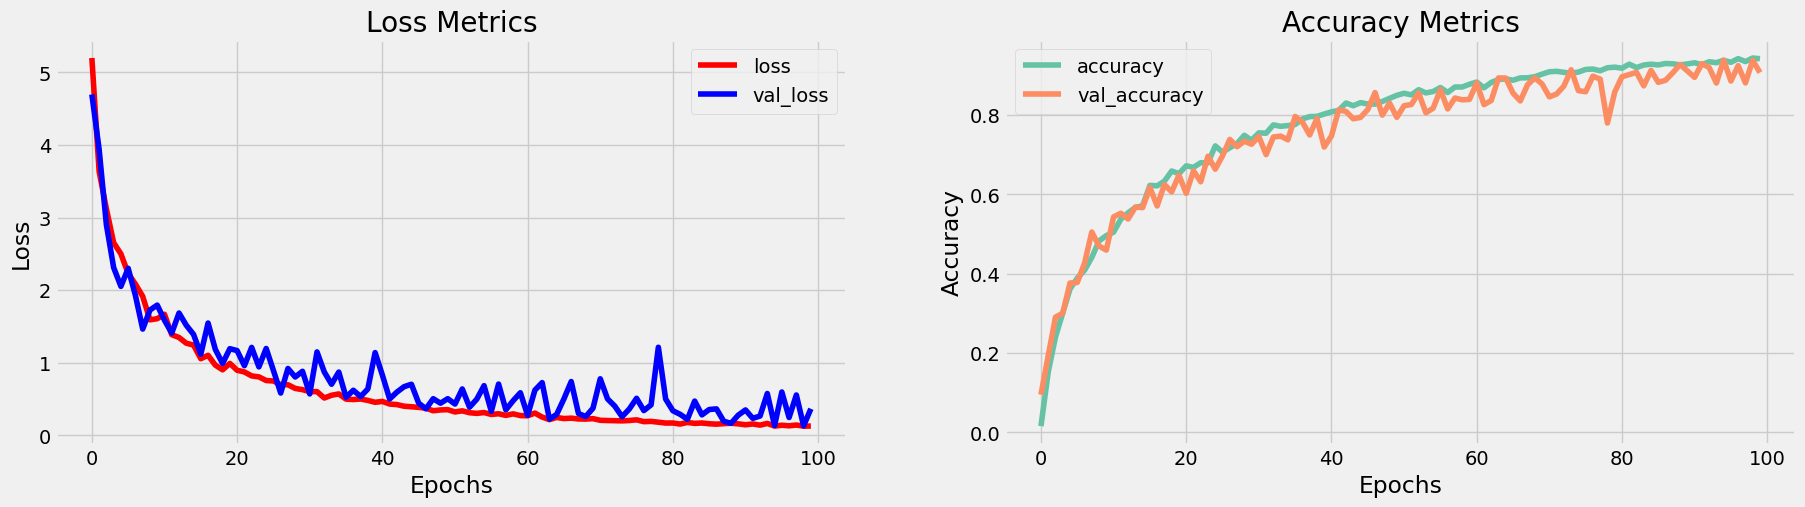

In [24]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
ax[0].plot(history.history['loss'],label='loss',c='red')
ax[0].plot(history.history['val_loss'],label='val_loss',c = 'blue')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[0].set_title('Loss Metrics')
ax[1].set_title('Accuracy Metrics')
ax[1].plot(history.history['accuracy'],label='accuracy')
ax[1].plot(history.history['val_accuracy'],label='val_accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

In [25]:
model.load_weights('ckpt1')
model.save('models',save_format='tf')

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


In [26]:
for idx,i in enumerate(model.layers):
    print('Encoder layers:' if idx==0 else 'Decoder layers: ')
    for j in i.layers:
        print(j)
    print('---------------------')

Encoder layers:
---------------------
Decoder layers: 
---------------------


In [27]:
class ChatBot(tf.keras.models.Model):
    def __init__(self,base_encoder,base_decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder,self.decoder=self.build_inference_model(base_encoder,base_decoder)

    def build_inference_model(self,base_encoder,base_decoder):
        encoder_inputs=tf.keras.Input(shape=(None,))
        x=base_encoder.layers[0](encoder_inputs)
        x=base_encoder.layers[1](x)
        x,encoder_state_h,encoder_state_c=base_encoder.layers[2](x)
        encoder=tf.keras.models.Model(inputs=encoder_inputs,outputs=[encoder_state_h,encoder_state_c],name='chatbot_encoder')

        decoder_input_state_h=tf.keras.Input(shape=(lstm_cells,))
        decoder_input_state_c=tf.keras.Input(shape=(lstm_cells,))
        decoder_inputs=tf.keras.Input(shape=(None,))
        x=base_decoder.layers[0](decoder_inputs)
        x=base_encoder.layers[1](x)
        x,decoder_state_h,decoder_state_c=base_decoder.layers[2](x,initial_state=[decoder_input_state_h,decoder_input_state_c])
        decoder_outputs=base_decoder.layers[-1](x)
        decoder=tf.keras.models.Model(
            inputs=[decoder_inputs,[decoder_input_state_h,decoder_input_state_c]],
            outputs=[decoder_outputs,[decoder_state_h,decoder_state_c]],name='chatbot_decoder'
        )
        return encoder,decoder

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()

    def softmax(self,z):
        return np.exp(z)/sum(np.exp(z))

    def sample(self,conditional_probability,temperature=0.5):
        conditional_probability = np.asarray(conditional_probability).astype("float64")
        conditional_probability = np.log(conditional_probability) / temperature
        reweighted_conditional_probability = self.softmax(conditional_probability)
        probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
        return np.argmax(probas)

    def preprocess(self,text):
        text=clean_text(text)
        seq=np.zeros((1,max_sequence_length),dtype=np.int32)
        for i,word in enumerate(text.split()):
            seq[:,i]=sequences2ids(word).numpy()[0]
        return seq
    
    def postprocess(self,text):
        text=re.sub(' - ','-',text.lower())
        text=re.sub(' [.] ','. ',text)
        text=re.sub(' [1] ','1',text)
        text=re.sub(' [2] ','2',text)
        text=re.sub(' [3] ','3',text)
        text=re.sub(' [4] ','4',text)
        text=re.sub(' [5] ','5',text)
        text=re.sub(' [6] ','6',text)
        text=re.sub(' [7] ','7',text)
        text=re.sub(' [8] ','8',text)
        text=re.sub(' [9] ','9',text)
        text=re.sub(' [0] ','0',text)
        text=re.sub(' [,] ',', ',text)
        text=re.sub(' [?] ','? ',text)
        text=re.sub(' [!] ','! ',text)
        text=re.sub(' [$] ','$ ',text)
        text=re.sub(' [&] ','& ',text)
        text=re.sub(' [/] ','/ ',text)
        text=re.sub(' [:] ',': ',text)
        text=re.sub(' [;] ','; ',text)
        text=re.sub(' [*] ','* ',text)
        text=re.sub(' [\'] ','\'',text)
        text=re.sub(' [\"] ','\"',text)
        return text

    def call(self,text,config=None):
        input_seq=self.preprocess(text)
        states=self.encoder(input_seq,training=False)
        target_seq=np.zeros((1,1))
        target_seq[:,:]=sequences2ids(['<start>']).numpy()[0][0]
        stop_condition=False
        decoded=[]
        while not stop_condition:
            decoder_outputs,new_states=self.decoder([target_seq,states],training=False)
#             index=tf.argmax(decoder_outputs[:,-1,:],axis=-1).numpy().item()
            index=self.sample(decoder_outputs[0,0,:]).item()
            word=ids2sequences([index])
            if word=='<end> ' or len(decoded)>=max_sequence_length:
                stop_condition=True
            else:
                decoded.append(index)
                target_seq=np.zeros((1,1))
                target_seq[:,:]=index
                states=new_states
        return self.postprocess(ids2sequences(decoded))

chatbot=ChatBot(model.encoder,model.decoder,name='chatbot')
chatbot.summary()

Model: "chatbot_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 encoder_embedding (Embeddin  (None, None, 256)        289792    
 g)                                                              
                                                                 
 layer_normalization (LayerN  (None, None, 256)        512       
 ormalization)                                                   
                                                                 
 encoder_lstm (LSTM)         [(None, None, 256),       525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 815,616
Trainable params: 815,616
Non

In [28]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Nuwanga Wijamuni\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [29]:
tf.keras.utils.plot_model(chatbot.encoder,to_file='encoder.png',show_shapes=True,show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [30]:
tf.keras.utils.plot_model(chatbot.decoder,to_file='decoder.png',show_shapes=True,show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [31]:
def print_conversation(texts):
    for text in texts:
        print(f'Patient: {text}')
        print(f'DocBot: {chatbot(text)}')
        print('========================')

In [32]:
print_conversation([
    'Hellow Doctor',
    '''I haven't noticed any significant swelling''',
    ''' I'm just a bit concerned about the severity of the reaction'''

])

Patient: Hellow Doctor
DocBot: hello, how can i assist you today? 
Patient: I haven't noticed any significant swelling
DocBot: escalate, it's crucial to act quickly. if you have been prescribed an epinephrine auto injector (epipen), make sure to carry it with you at all times and know know. it's important to 
Patient:  I'm just a bit concerned about the severity of the reaction
DocBot: it's important to monitor it further to further evaluation. if you have any further questions or concerns, don't hesitate to reach out. i'm here to support you. 


In [35]:
class RealTimeChatBot(tf.keras.models.Model):
    def __init__(self,base_encoder,base_decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder,self.decoder=self.build_inference_model(base_encoder,base_decoder)

    def build_inference_model(self,base_encoder,base_decoder):
        encoder_inputs=tf.keras.Input(shape=(None,))
        x=base_encoder.layers[0](encoder_inputs)
        x=base_encoder.layers[1](x)
        x,encoder_state_h,encoder_state_c=base_encoder.layers[2](x)
        encoder=tf.keras.models.Model(inputs=encoder_inputs,outputs=[encoder_state_h,encoder_state_c],name='chatbot_encoder')

        decoder_input_state_h=tf.keras.Input(shape=(lstm_cells,))
        decoder_input_state_c=tf.keras.Input(shape=(lstm_cells,))
        decoder_inputs=tf.keras.Input(shape=(None,))
        x=base_decoder.layers[0](decoder_inputs)
        x=base_encoder.layers[1](x)
        x,decoder_state_h,decoder_state_c=base_decoder.layers[2](x,initial_state=[decoder_input_state_h,decoder_input_state_c])
        decoder_outputs=base_decoder.layers[-1](x)
        decoder=tf.keras.models.Model(
            inputs=[decoder_inputs,[decoder_input_state_h,decoder_input_state_c]],
            outputs=[decoder_outputs,[decoder_state_h,decoder_state_c]],name='chatbot_decoder'
        )
        return encoder,decoder

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()

    def softmax(self,z):
        return np.exp(z)/sum(np.exp(z))

    def sample(self,conditional_probability,temperature=0.5):
        conditional_probability = np.asarray(conditional_probability).astype("float64")
        conditional_probability = np.log(conditional_probability) / temperature
        reweighted_conditional_probability = self.softmax(conditional_probability)
        probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
        return np.argmax(probas)

    def preprocess(self,text):
        text=clean_text(text)
        seq=np.zeros((1,max_sequence_length),dtype=np.int32)
        for i,word in enumerate(text.split()):
            seq[:,i]=sequences2ids(word).numpy()[0]
        return seq
    
    def postprocess(self,text):
        text=re.sub(' - ','-',text.lower())
        text=re.sub(' [.] ','. ',text)
        text=re.sub(' [1] ','1',text)
        text=re.sub(' [2] ','2',text)
        text=re.sub(' [3] ','3',text)
        text=re.sub(' [4] ','4',text)
        text=re.sub(' [5] ','5',text)
        text=re.sub(' [6] ','6',text)
        text=re.sub(' [7] ','7',text)
        text=re.sub(' [8] ','8',text)
        text=re.sub(' [9] ','9',text)
        text=re.sub(' [0] ','0',text)
        text=re.sub(' [,] ',', ',text)
        text=re.sub(' [?] ','? ',text)
        text=re.sub(' [!] ','! ',text)
        text=re.sub(' [$] ','$ ',text)
        text=re.sub(' [&] ','& ',text)
        text=re.sub(' [/] ','/ ',text)
        text=re.sub(' [:] ',': ',text)
        text=re.sub(' [;] ','; ',text)
        text=re.sub(' [*] ','* ',text)
        text=re.sub(' [\'] ','\'',text)
        text=re.sub(' [\"] ','\"',text)
        return text

    def call(self,text,config=None):
        input_seq=self.preprocess(text)
        states=self.encoder(input_seq,training=False)
        target_seq=np.zeros((1,1))
        target_seq[:,:]=sequences2ids(['<start>']).numpy()[0][0]
        stop_condition=False
        decoded=[]
        while not stop_condition:
            decoder_outputs,new_states=self.decoder([target_seq,states],training=False)
#             index=tf.argmax(decoder_outputs[:,-1,:],axis=-1).numpy().item()
            index=self.sample(decoder_outputs[0,0,:]).item()
            word=ids2sequences([index])
            if word=='<end> ' or len(decoded)>=max_sequence_length:
                stop_condition=True
            else:
                decoded.append(index)
                target_seq=np.zeros((1,1))
                target_seq[:,:]=index
                states=new_states
        return self.postprocess(ids2sequences(decoded))

    def chat(self):
        print("Bot: Hello! How can I assist you today?")
        while True:
            user_input = input('User: ')
            if user_input.lower() in ['quit', 'exit', 'bye']:
                print('Bot: Goodbye! Take care.')
                break
            response = self.call(user_input)
            print(f'Bot: {response}')

# Initialize and summarize chatbot
chatbot=RealTimeChatBot(model.encoder,model.decoder,name='chatbot')
chatbot.summary()

# Start a real-time chat with the chatbot
chatbot.chat()


Model: "chatbot_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None)]            0         
                                                                 
 encoder_embedding (Embeddin  (None, None, 256)        289792    
 g)                                                              
                                                                 
 layer_normalization (LayerN  (None, None, 256)        512       
 ormalization)                                                   
                                                                 
 encoder_lstm (LSTM)         [(None, None, 256),       525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 815,616
Trainable params: 815,616
Non